In [1]:
#import spikeinterface modules
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import numpy as np
import glob

#import everything else
import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

from time import strftime
%matplotlib inline

In [2]:
filedirec = r"D:\MEA_DATA_Aachen\ANALYZED\20210510_cortex_div4"
inputdirectory = r"D:\MEA_DATA_Aachen\PREPROCESSED\20210510_cortex_div4"
os.chdir(inputdirectory)

In [3]:
filelist = glob.glob('*.h5')
filelist

['2021-05-10T13-50-07__cortex_div4_hCSF_ID039_nodrug_spont_1__.h5',
 '2021-05-10T14-05-26__cortex_div4_hCSF_ID039_30µMCNQX_spont_1__.h5']

In [4]:
labeldic = np.load(r'C:\Users\User\Documents\JO\gitkraken\MEA_analysis\basic_inputs\labeldictionary_MCS_256MEA.npy', allow_pickle='TRUE').item()

In [5]:
filename=filelist[0]


In [6]:
filebase = filename.split('.')[0]

In [7]:
filebase

'2021-05-10T13-50-07__cortex_div4_hCSF_ID039_nodrug_spont_1__'

In [8]:
recording_MEA=se.MCSH5RecordingExtractor(os.path.join(inputdirectory, filename))
recording_f = st.preprocessing.bandpass_filter(recording_MEA, freq_min=150, freq_max=5000, filter_type='butter', order=2)
recording_cmr = st.preprocessing.common_reference(recording_f, reference='median')


In [10]:
recording_cmrprobe=recording_MEA.load_probe_file(probe_file="C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Spikesorting/MCS_MEA_256_100µM_spacing.prb")

In [11]:
#timestr = strftime("%d%m%Y")
#outputdirectory = os.path.join(filedirec, '_output_Spikesorting_'+ timestr).replace('\\','/')

probe_file="C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Spikesorting/MCS_MEA_256_100µM_spacing.prb"
#outputdirectory_SC='D:/Files_Reutlingen_Jenny/main_191021extra/191021_extra_Spikesorting/output_Spykingcirucs'
outputdirectory = 'D:/MEA_DATA_Aachen/ANALYZED/20210510_cortex_div4/_output_Spikesorting_02062021'


In [12]:
outputdirectory

'D:/MEA_DATA_Aachen/ANALYZED/20210510_cortex_div4/_output_Spikesorting_02062021'

In [13]:
outpath=os.path.join(outputdirectory+'_'+filename.split('.')[0]+'_spikesorting').replace("\\","/")
try:
    os.mkdir(outpath)
except OSError:
    print ("Creation of the directory %s failed" % outpath)
else:
    print ("Successfully created the directory %s " % outpath)

Successfully created the directory D:/MEA_DATA_Aachen/ANALYZED/20210510_cortex_div4/_output_Spikesorting_02062021_2021-05-10T13-50-07__cortex_div4_hCSF_ID039_nodrug_spont_1___spikesorting 


In [16]:
# outpath_SC=os.path.join(outpath, 'output_spykingcircus').replace("\\","/")
# try:
#     os.mkdir(outpath_SC)
# except OSError:
#     print ("Creation of the directory %s failed" % outpath)
# else:
#     print ("Successfully created the directory %s " % outpath)

Successfully created the directory D:/MEA_DATA_Aachen/ANALYZED/20210510_cortex_div4/_output_Spikesorting_02062021_2021-05-10T13-50-07__cortex_div4_hCSF_ID039_nodrug_spont_1___spikesorting 


In [16]:
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_23042021_hCSF_adult_20min_spont0002_spikesorting'
outpath = r'D:\MEA_DATA_Aachen\ANALYZED\20210510_cortex_div4\_output_Spikesorting_02062021_cortex_div4_hCSF_ID039_nodrug_spont_1_spikesorting'

In [17]:
os.chdir(outpath)

In [15]:
# cutting out 2 minutes

fs = recording_cmrprobe.get_sampling_frequency()
fs = np.round(fs)
#recording_sub = se.SubRecordingExtractor(recording_cmrprobe, start_frame=200*fs, end_frame=320*fs)

In [16]:
# get the recording length, divide it into 120 second frames
recording_length = recording_cmrprobe.get_num_frames()
recording_seconds = recording_length/fs




In [17]:
def divide_recording_to_sub(recording, sublength_seconds):
    
    
    subrecording_dic = {}
    recording_length = recording.get_num_frames()
    recording_seconds = recording_length/fs
    end_frame = int(recording_seconds)
    
    for snippet in range(0, end_frame, sublength_seconds):
        sub_start = snippet
        sub_end = snippet + sublength_seconds
        if sub_end > end_frame:
            sub_end = end_frame
        sub_str = 'sec_'+str(sub_start)+'-'+str(sub_end)
    
        subrecording_dic[sub_str] = se.SubRecordingExtractor(
            recording_cmrprobe, start_frame = sub_start*fs,
            end_frame = sub_end*fs)
    
    return subrecording_dic
    
    

In [18]:
subrecords = divide_recording_to_sub(recording_cmrprobe, 300)

In [19]:
subrecords

{'sec_0-130': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x20e05174cd0>}

In [20]:
# make a cache for every part in the dictionary

def create_cache_for_subrecordings(subrecording_dic, filebase, outpath):

    for key in subrecording_dic:
        sub_cache = se.CacheRecordingExtractor(
            subrecording_dic[key])
        filepath = os.path.join(
            outpath, filebase+str(key)+'_filtered_data.dat'
            ).replace('\\','/')
        sub_cache.move_to(filepath) 
        sub_cache.dump_to_dict()
        filepathpickle = os.path.join(
            outpath, filebase+str(key)+'_recording.pkl'
            ).replace('\\','/')
        sub_cache.dump_to_pickle(filepathpickle)
        
    return 'Finished dumping the subrecords. To load, use the load_dumped_recordings function'
    

In [21]:
create_cache_for_subrecordings(subrecording_dic=subrecords, filebase=filebase, outpath=outpath)

'Finished dumping the subrecords. To load, use the load_dumped_recordings function'

In [19]:
def load_dumped_subrecordings(directory, filebase):

    subrecording_dic = {}
    filelist = glob.glob('*.pkl')
    for file in filelist:
        key = file.split(filebase)[1].split('.')[0].split('_recording')[0]
        subrecording_dic[key]=se.load_extractor_from_pickle(file)
        
    return subrecording_dic
        
    

In [20]:
loaded = load_dumped_subrecordings(outpath, filebase)

IndexError: list index out of range

In [24]:
loaded

{'sec_0-130': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x20e5702bc10>}

In [25]:
outpath_SC

NameError: name 'outpath_SC' is not defined

In [148]:
# to load:
#recording_loaded = se.load_extractor_from_pickle('recording.pkl')
#recording_cache=recording_loaded

In [26]:
# loop to run spikesorter over different subrecordings
def run_spykingcircus_on_sub(subrecording_dic, directory):
    

    sorted_dic={}
    for key in loaded:
        outpath_SC=os.path.join(outpath, 'sorted_'+str(key)).replace('\\', '/')
        '''
        try:
            os.mkdir(outpath_SC)
        except OSError:
            print ("Creation of the directory %s failed" % outpath)
        else:
            print ("Successfully created the directory %s " % outpath)
        '''
        sorted_dic[key]=ss.run_spykingcircus(
            loaded[key], output_folder=outpath_SC)

    return sorted_dic
    

In [27]:
sorted_dic = run_spykingcircus_on_sub(loaded, outpath)

RUNNING SHELL SCRIPT: D:\MEA_DATA_Aachen\ANALYZED\20210510_cortex_div4\_output_Spikesorting_02062021_2021-05-10T13-50-07__cortex_div4_hCSF_ID039_nodrug_spont_1___spikesorting\sorted_sec_0-130\run_spykingcircus.bat


Exception: (WindowsPath('D:/MEA_DATA_Aachen/ANALYZED/20210510_cortex_div4/_output_Spikesorting_02062021_2021-05-10T13-50-07__cortex_div4_hCSF_ID039_nodrug_spont_1___spikesorting/sorted_sec_0-130/recording'), ' is not a spyking circus folder')

In [31]:
ss.get_sorter_description('spykingcircus')

'Spyking Circus uses a smart clustering and a greedy template matching approach for \n    spike sorting. For more information see https://doi.org/10.7554/eLife.34518'

In [151]:
sorted_dic

{'sec_0-300': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x1a5a0152b50>,
 'sec_300-600': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x1a5a0102c70>,
 'sec_600-900': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x1a5a01020a0>,
 'sec_900-969': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x1a5a011fca0>}

In [15]:
def load_dumped_sorted_dic(outpath):

    sorted_dic = {}
    filelist = glob.glob('*sorted*')
    for file in filelist:
        key = file.split('sorted_')[1]
        sorted_dic[key]=se.SpykingCircusSortingExtractor(file)
        
    return sorted_dic

In [42]:
sorted_dic = load_dumped_sorted_dic(outpath)

In [43]:
sorted_dic


{'sec_0-300': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x27381e0da30>,
 'sec_300-600': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x273819969a0>,
 'sec_600-900': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x268eda985b0>,
 'sec_900-969': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x27381d65730>}

In [18]:
waveforms = st.postprocessing.get_unit_waveforms(
    loaded['sec_0-300'], sorted_dic['sec_0-300'], memmap = True
    )

In [18]:
u = 'sec_0-300'

In [19]:
layerdic = {'layer1':[], 
            'layer2-3':['L1', 'M1', 'M2', 'M3', 'M15', 'M16', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7',
                        'N8', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'O1', 'O2', 'O3', 'O4', 
                        'O5', 'O6', 'O7', 'O8', 'O9', 'O10', 'O11', 'O12', 'O13', 'O14', 'O15', 'O16', 'P1', 
                        'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 
                        'P15', 'P16', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 
                        'R13', 'R14', 'R15'],
           'layer4':['K1', 'K2', 'K14', 'K15', 'K16', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 
                     'L13', 'L14', 'L15', 'L16', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14'],
           'layer5-6':['K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'I1', 'I2', 'I3', 'I4', 
                       'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'H1', 'H2', 'H3', 
                       'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 
                      'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16',
                       'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16',
                       'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16',
                       'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11'],
           'whitematter':['D12', 'D13', 'D14', 'D15', 'D16', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
                          'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 
                          'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 
                          'A10', 'A11', 'A12', 'A13', 'A14', 'A15' ]}

In [20]:
# loop to invert
layerdic_invert = {}

for key in layerdic:
    for i in layerdic[key]:
        layerdic_invert[i]=key

In [21]:
labeldic_invert = {}

for key in labeldic:
    keystring = str(labeldic[key])
    labeldic_invert[keystring] = key

In [22]:
labeldic_invert

{'R12': 0,
 'L10': 1,
 'O10': 2,
 'P11': 3,
 'L9': 4,
 'N9': 5,
 'M8': 6,
 'R8': 7,
 'O6': 8,
 'N7': 9,
 'R4': 10,
 'P5': 11,
 'R2': 12,
 'M5': 13,
 'K6': 14,
 'I8': 15,
 'L2': 16,
 'M1': 17,
 'I4': 18,
 'K3': 19,
 'H1': 20,
 'I6': 21,
 'G4': 22,
 'H5': 23,
 'E2': 24,
 'F3': 25,
 'N13': 26,
 'O14': 27,
 'R13': 28,
 'L11': 29,
 'O11': 30,
 'P12': 31,
 'M9': 32,
 'N10': 33,
 'L8': 34,
 'R9': 35,
 'O7': 36,
 'N8': 37,
 'R5': 38,
 'P6': 39,
 'K7': 40,
 'L7': 41,
 'N4': 42,
 'O3': 43,
 'N1': 44,
 'L6': 45,
 'L3': 46,
 'M2': 47,
 'I5': 48,
 'K4': 49,
 'H6': 50,
 'I1': 51,
 'G3': 52,
 'H4': 53,
 'E1': 54,
 'F2': 55,
 'K13': 56,
 'L16': 57,
 'I12': 58,
 'K15': 59,
 'I16': 60,
 'I14': 61,
 'K10': 62,
 'O16': 63,
 'R14': 64,
 'R15': 65,
 'O12': 66,
 'P13': 67,
 'M10': 68,
 'N11': 69,
 'P9': 70,
 'R10': 71,
 'O8': 72,
 'K8': 73,
 'R6': 74,
 'P7': 75,
 'N5': 76,
 'M6': 77,
 'P3': 78,
 'O4': 79,
 'O1': 80,
 'P1': 81,
 'M3': 82,
 'N2': 83,
 'K5': 84,
 'L4': 85,
 'I2': 86,
 'K1': 87,
 'H3': 88,
 'H7'

In [23]:
#load
#sorting_SC = se.SpykingCircusSortingExtractor(outpath_SC)


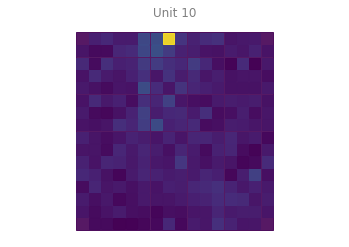

In [44]:
sw.plot_unit_template_maps(loaded['sec_0-300'],  sorted_dic['sec_0-300'], max_spikes_per_unit=100, unit_ids=[10])

{}


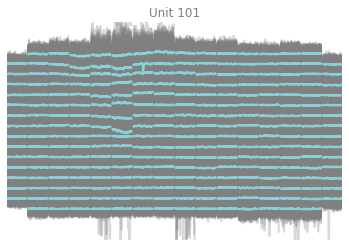

In [23]:
w_wf = sw.plot_unit_waveforms(loaded['sec_0-300'],  sorted_dic['sec_0-300'], unit_ids=[101], color='#89D1D9')

<IPython.core.display.Javascript object>


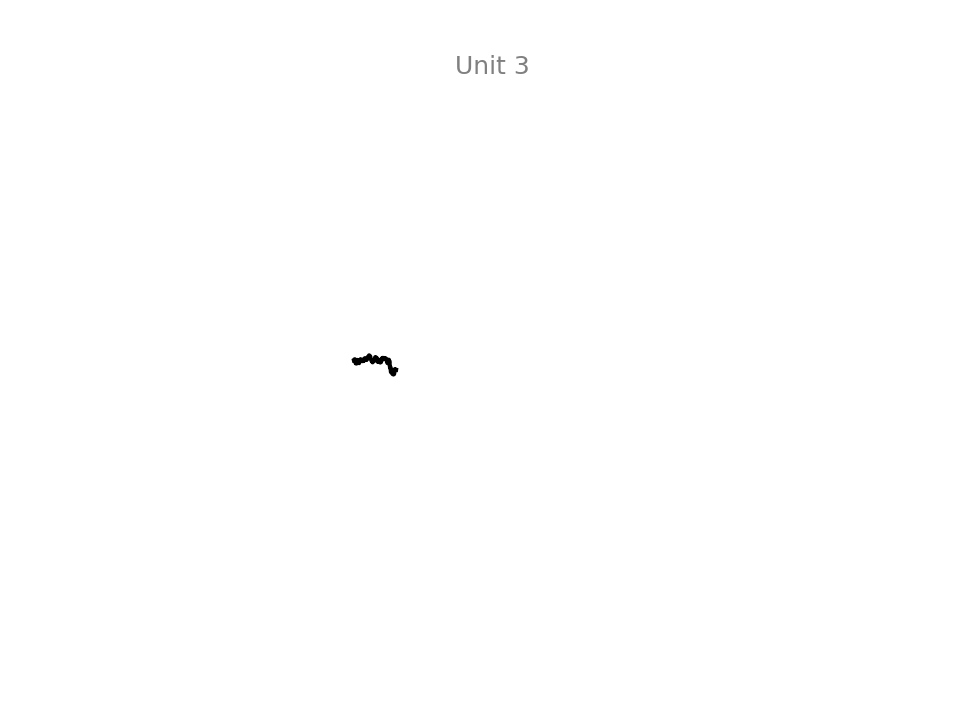

{}


In [132]:
sw.plot_unit_templates(loaded['sec_0-300'],  sorted_dic['sec_0-300'], unit_ids=[3], max_channels=1, )

In [61]:
def units_to_pandas_DataFrame(sorted_dic, recording_cache, dictkey, layerdic_invert, recordingdate='not given'):
    
    # creates pandas DataFrame only including the unit ids. the order will be confused because of the unit numbering ('1' instead of '001')
    unit_ids = sorted_dic[dictkey].get_unit_ids()
    unitframe = pd.DataFrame(
        sorted_dic[dictkey].get_unit_ids(), 
        columns=['unit_ids']
        )
    
    
    list_not_empty_spiketrains = []
    for i in unit_ids:
        st_len = len(sorted_dic[dictkey].get_unit_spike_train(unit_id=i))
        if st_len > 0:
            list_not_empty_spiketrains.append(i)
    
    
    # calculate as many paramters as possible outside of the loop
    recordings_seconds = recording_cache[dictkey].get_num_frames()/recording_cache[dictkey].get_sampling_frequency()
    
#     features = st.postprocessing.compute_unit_template_features(
#         recording_cache[dictkey], 
#         sorted_dic[dictkey], 
#         as_dataframe=True
#         )
    
#     quality_metrics = st.validation.compute_quality_metrics(
#         sorted_dic[dictkey], 
#         recording_cache[dictkey], 
#         metric_names=['firing_rate', 'isi_violation', 'snr', 
#                       'amplitude_cutoff', 'presence_ratio'],
#         as_dataframe=True
#         )
    
    
    for i in list_not_empty_spiketrains:  
        
        # add channel with maximum amplitude
        unitframe.loc[(unitframe['unit_ids']==i), 'max_channel']=st.postprocessing.get_unit_max_channels(
            recording_cache[dictkey], sorted_dic[dictkey], unit_ids=[i]
            )
    
        # get the channel label as on MCS MEA 256 chips
        max_channel = int(unitframe.loc[(unitframe['unit_ids']==i)]['max_channel'])
        unitframe.loc[(unitframe['unit_ids']==i), 'channellabel']= labeldic[max_channel]
        
        # get the number of spiks per unit
        unitframe.loc[(unitframe['unit_ids']==i), 'n_spikes']=len(sorted_dic[dictkey].get_unit_spike_train(unit_id=i))
        
        # add firing rate
        unitframe.loc[(unitframe['unit_ids']==i), 'firing_rate']= unitframe.loc[(unitframe['unit_ids']==i)]['n_spikes']/recordings_seconds
        
        # add layer
        labelkey = unitframe.loc[(unitframe['unit_ids']==i), 'channellabel'].values[0]
        unitframe.loc[(unitframe['unit_ids']==i), 'layer']= layerdic_invert[labelkey]
        
        # add features
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_peak_to_valley']=features.loc[i]['peak_to_valley']
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_halfwidth']=features.loc[i]['halfwidth']
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_peak_trough_ratio']=features.loc[i]['peak_trough_ratio']
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_repolarization_slope']=features.loc[i]['repolarization_slope']
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_recovery_slope']=features.loc[i]['recovery_slope']

        # add quality metrics
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_firing_rate']=quality_metrics.loc[i]['firing_rate']
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_isi_violation']=quality_metrics.loc[i]['isi_violation']
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_amplitude_cutoff']=quality_metrics.loc[i]['amplitude_cutoff']
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_presence_ratio']=quality_metrics.loc[i]['presence_ratio']
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_snr']=quality_metrics.loc[i]['snr']
        
        
        unitframe.loc[(unitframe['unit_ids']==i), 'file']=filebase
        unitframe.loc[(unitframe['unit_ids']==i), 'subrecording']=dictkey
        unitframe.loc[(unitframe['unit_ids']==i), 'recordingdate']=recordingdate
    return unitframe

In [62]:
unitframe3 = units_to_pandas_DataFrame(
    sorted_dic = sorted_dic,
    recording_cache = loaded,
    dictkey='sec_600-900',
    layerdic_invert=layerdic_invert,
    recordingdate = '21.10.2019'
    )

ValueError: cannot mmap an empty file

In [76]:
features = st.postprocessing.compute_unit_template_features(
        loaded['sec_0-300'], 
        sorted_dic['sec_0-300'], 
        as_dataframe=True, 
        unit_ids = list_not_empty_spiketrains
        )

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


IndexError: list index out of range

In [66]:
quality_metrics = st.validation.compute_quality_metrics(
    sorted_dic['sec_0-300'], 
    loaded['sec_0-300'], 
    metric_names=['firing_rate', 'isi_violation', 'snr', 
                  'amplitude_cutoff', 'presence_ratio'],
    as_dataframe=True,
    unit_ids=list_not_empty_spiketrains
    )



ValueError: Spike trains must have none zero length. Please remove all zero length spike trains

In [64]:
list_not_empty_spiketrains = []

ids = sorted_dic['sec_0-300'].get_unit_ids()
for i in ids:
    st_len = len(sorted_dic['sec_0-300'].get_unit_spike_train(unit_id=i))
    if st_len > 0:
        list_not_empty_spiketrains.append(i)

In [73]:
len(ids)

966

In [46]:
sorted_dic[u]

In [47]:
features = st.postprocessing.compute_unit_template_features(
    loaded[u], 
    sorted_dic[u], 
    as_dataframe=True
    )


C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [37]:
features

,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope
0,0.00132,0.00032,-0.308642,0.032623,-0.003106
1,0.00112,0.00028,-0.366667,0.017728,-0.002502
10,0.00120,0.00028,0.116998,NaN,-0.000533
100,0.00108,0.00044,-0.258162,0.169479,-0.023654
101,0.00080,0.00036,-0.324324,0.147332,-0.014374
...,...,...,...,...,...
95,0.00044,0.00024,-0.263305,0.086346,-0.009415
96,0.00188,0.00044,0.037855,NaN,-0.009115
97,0.00184,0.00048,0.013889,NaN,-0.009115
98,0.00064,0.00036,0.107639,NaN,-0.001133


In [39]:
len(unitframe['channellabel'].unique())

248

In [66]:
# get data to compare firingrate
unitframe_fr_filtered = unitframe[(unitframe['firing_rate']>=0.5)]

layer2_3 = unitframe.loc[unitframe.layer == 'layer2-3', 'firing_rate']
layer4 = unitframe.loc[unitframe.layer == 'layer4', 'firing_rate']
layer5_6 = unitframe.loc[unitframe.layer == 'layer5-6', 'firing_rate']
wm = unitframe.loc[unitframe.layer == 'whitematter', 'firing_rate']

In [ ]:
unitframe_fr_filtered = unitframe[(unitframe['firing_rate']>=0.5)]

In [107]:
plt.style.use("seaborn")

In [95]:
layer2_3 = unitframe_fr_filtered.loc[unitframe_fr_filtered.layer == 'layer2-3', 'firing_rate']
layer4 = unitframe_fr_filtered.loc[unitframe_fr_filtered.layer == 'layer4', 'firing_rate']
layer5_6 = unitframe_fr_filtered.loc[unitframe_fr_filtered.layer == 'layer5-6', 'firing_rate']
wm = unitframe_fr_filtered.loc[unitframe_fr_filtered.layer == 'whitematter', 'firing_rate']

In [ ]:
plt.hist(x1, **kwargs, color='g', label='Ideal')
plt.hist(x2, **kwargs, color='b', label='Fair')
plt.hist(x3, **kwargs, color='r', label='Good')
plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
plt.xlim(50,75)
plt.legend();

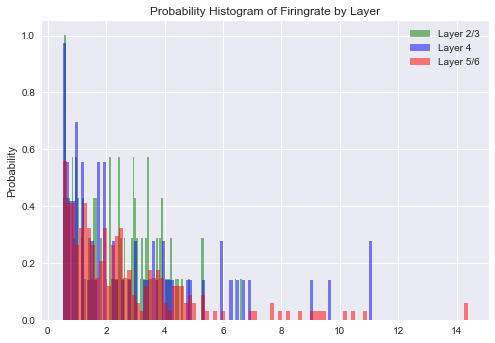

In [108]:
kwargs = dict(alpha=0.5, bins=100, density = True, stacked = True)

plt.hist(layer2_3, **kwargs, color='g', label='Layer 2/3')
plt.hist(layer4, **kwargs, color='b', label = 'Layer 4')
plt.hist(layer5_6, **kwargs, color='r', label = 'Layer 5/6')
plt.gca().set(title='Probability Histogram of Firingrate by Layer', ylabel='Probability')
plt.legend()

In [98]:
import seaborn as sns

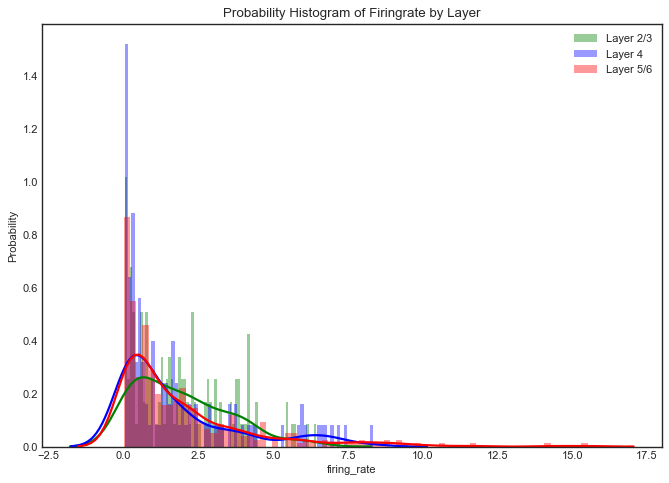

In [67]:

kwargs = dict(hist_kws={'alpha':.4}, kde_kws={'linewidth':2}, bins=75)

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(layer2_3, **kwargs, color='g', label='Layer 2/3')
sns.distplot(layer4, **kwargs, color='b', label = 'Layer 4')
sns.distplot(layer5_6, **kwargs, color='r', label = 'Layer 5/6')
#sns.distplot(wm, **kwargs, color='y', label = 'Whitematter')
plt.gca().set(title='Probability Histogram of Firingrate by Layer', ylabel='Probability')
plt.legend()

In [115]:
# signal to noise ratio
snr_layer2_3 = unitframe.loc[unitframe.layer == 'layer2-3', 'qm_snr']
snr_layer4 = unitframe.loc[unitframe.layer == 'layer4', 'qm_snr']
snr_layer5_6 = unitframe.loc[unitframe.layer == 'layer5-6', 'qm_snr']
snr_wm = unitframe.loc[unitframe.layer == 'whitematter', 'qm_snr']

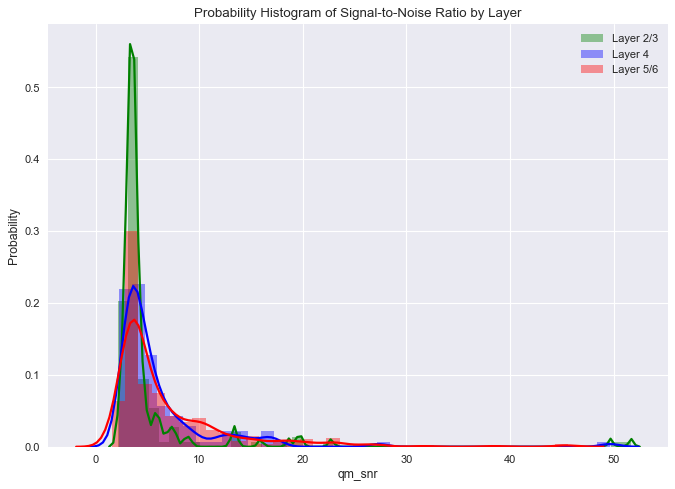

In [128]:
kwargs = dict(hist_kws={'alpha':.4}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(snr_layer2_3, **kwargs, color='g', label='Layer 2/3')
sns.distplot(snr_layer4, **kwargs, color='b', label = 'Layer 4')
sns.distplot(snr_layer5_6, **kwargs, color='r', label = 'Layer 5/6')
#sns.distplot(snr_wm, **kwargs, color='y', label = 'Whitematter')
plt.gca().set(title='Probability Histogram of Signal-to-Noise Ratio by Layer', ylabel='Probability')
plt.legend()

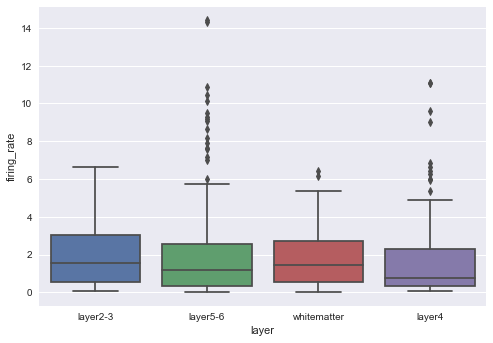

In [131]:
ax = sns.boxplot(x="layer", y="firing_rate", data=unitframe)

In [ ]:
ax = sns.boxplot(x="layer", y="firing_rate", data=unitframe)

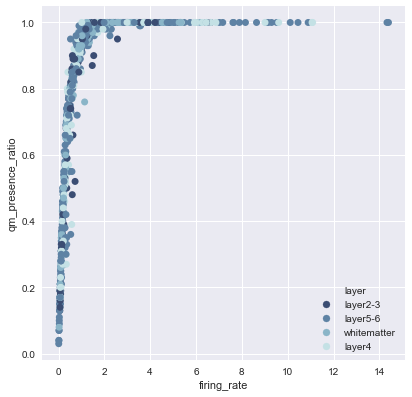

In [140]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="firing_rate", y="qm_presence_ratio",
                hue="layer",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=unitframe, ax=ax)


In [33]:
u = 'sec_300-600'

# Waveforms and Template Plots

In [34]:
# calculate waveforms 
wf = st.postprocessing.get_unit_waveforms(loaded[u], sorted_dic[u], ms_before=1, ms_after=2,
                                          save_as_features=True, verbose=True)

Number of chunks: 31 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##################################################| 31/31 [08:17<00:00, 16.05s/it]


In [48]:
print(sorted_dic[u].get_shared_unit_spike_feature_names())
print(wf[0].shape)

['amplitudes', 'amplitudes_idxs', 'waveforms', 'waveforms_idxs']
(52, 252, 148)


In [49]:
#fig, ax = plt.subplots()
#ax.plot(wf[0][:, 0, :].T, color='k', lw=0.3)

In [76]:
templates = st.postprocessing.get_unit_templates(loaded[u], sorted_dic[u], max_spikes_per_unit=200, 
                                                 save_as_property=True, verbose=True)

In [51]:
unitframe.loc[2]

unit_ids                                       10
max_channel                                    30
channellabel                                  O11
n_spikes                                      281
firing_rate                              0.936667
layer                                    layer2-3
ft_peak_to_valley                         0.00084
ft_halfwidth                              0.00032
ft_peak_trough_ratio                    -0.179012
ft_repolarization_slope                  0.042495
ft_recovery_slope                      -0.0048764
qm_firing_rate                           0.936667
qm_isi_violation                          11.5521
qm_amplitude_cutoff                   0.000920956
qm_presence_ratio                            0.88
qm_snr                                    4.33931
file                       aCSF_adult_15min_spont
Name: 2, dtype: object

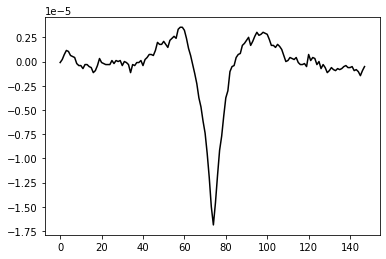

In [52]:
fig, ax = plt.subplots()
ax.plot(templates[2][30].T, color='k')


In [49]:
labeldic[40]

'K7'

idee: templates pro channel darstellen -> also den dataframe nach channel sortieren, dich mit key: channel, value: units

In [50]:
unitlist_by_index = list(unitframe.loc[(unitframe['max_channel'])==0].index)

In [51]:
unitlist_by_channel = list(unitframe.loc[(unitframe['max_channel'])==1]['unit_ids'])

In [52]:
unitlist_by_channel

[80, 81, 82]

In [82]:
j = 0 #entsprich dem maxchannel
#j=labeldic_invert['F8'] 
unitlist_by_index=unitframe.loc[(unitframe['max_channel']==j)].index
unitlist_by_channel = list(unitframe.loc[(unitframe['max_channel'])==j]['unit_ids'])
print(unitlist_by_index)
unitframe.loc[unitlist_by_index[0]]['channellabel']

Int64Index([0], dtype='int64')


'R12'

In [83]:
labeldic_invert[unitframe.loc[unitlist_by_index[0]]['channellabel']]

0

In [84]:
unitlist_by_index

Int64Index([0], dtype='int64')

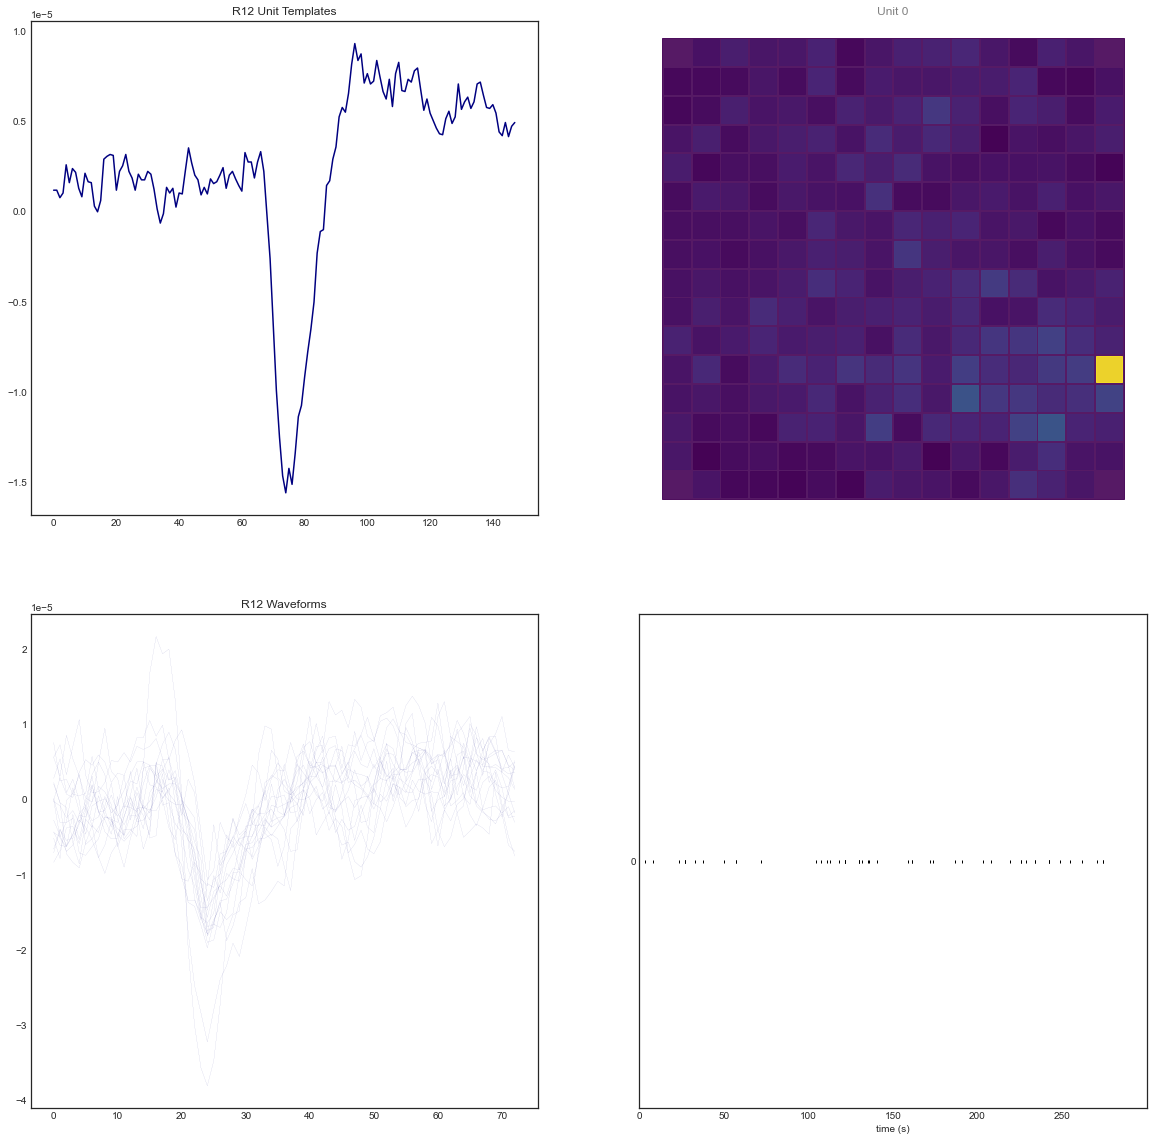

In [87]:
#colourlist = ['#D7D7D9', '#162473', '#449CA6', '#038C73', '#BF4417', '#7EBF88', '#D0F2D3', '#F2CB57']
n = len(unitlist_by_index)
colors = iter(cm.jet(np.linspace(0, 1, len(unitlist_by_index))))

plt.style.use("seaborn-white")

#fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,10))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))
      
sw.plot_unit_template_maps(loaded['sec_0-300'],  sorted_dic['sec_0-300'], max_spikes_per_unit=100, unit_ids=[(unitlist_by_channel[0])], ax=ax2)



#ax3.plot(loaded['sec_0-300'].get_traces()[j])

#sw.plot_timeseries(loaded['sec_0-300'], trange=[5, 8], ax=ax3,)

#sw.plot_activity_map(loaded['sec_0-300'], ax=ax3)

for i in unitlist_by_index:
    colourcode = color=next(colors)
    ax1.plot(templates[i][j].T, color=colourcode)
    ax1.set_title(str(unitframe.loc[i]['channellabel']) + ' Unit Templates')

    ax3.plot(wf[i][:, j, :].T, color=colourcode, lw=0.05)
    ax3.set_title(str(unitframe.loc[i]['channellabel']) + ' Waveforms')
    
#sw.plot_crosscorrelograms(sorted_dic['sec_0-300'], unit_ids=unitlist_by_index, ax=ax4, bin_size=1, window=10)
    
    
sw.plot_rasters(sorted_dic[u], color='k', unit_ids=unitlist_by_channel, ax = ax4)

#sw.plot_pca_features(sorting=sorted_dic[u], recording = loaded[u], unit_ids=unitlist_by_channel, ax=ax6)



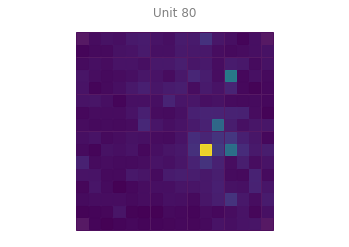

In [336]:
sw.plot_unit_template_maps(loaded['sec_0-300'],  sorted_dic['sec_0-300'], max_spikes_per_unit=100, unit_ids=[80], figure=)

In [ ]:
Continue 22/04:
    - fill in the dataframe with the other parameters
    - dump/pickle the data frame
    - make a plot for every unit

In [ ]:
waveforms = st.postprocessing.get_unit_waveforms(loaded['sec_0-300'], sorted_dic['sec_0-300'], ms_before=1, ms_after=2,
                                          save_as_features=True, verbose=True)

In [125]:
u = 'sec_0-300'

R12
Int64Index([0, 1], dtype='int64')
O11
Int64Index([2, 13, 430, 725, 736], dtype='int64')
F8
Int64Index([  3,   8,  41,  72,  74,  75,  76,  80,  96,  97,  98,  99, 100,
            107, 171, 207, 223, 340, 512, 531, 532, 549, 603, 682],
           dtype='int64')
G2
Int64Index([4, 5, 6, 7, 746], dtype='int64')
P10
Int64Index([9, 10, 11, 12], dtype='int64')


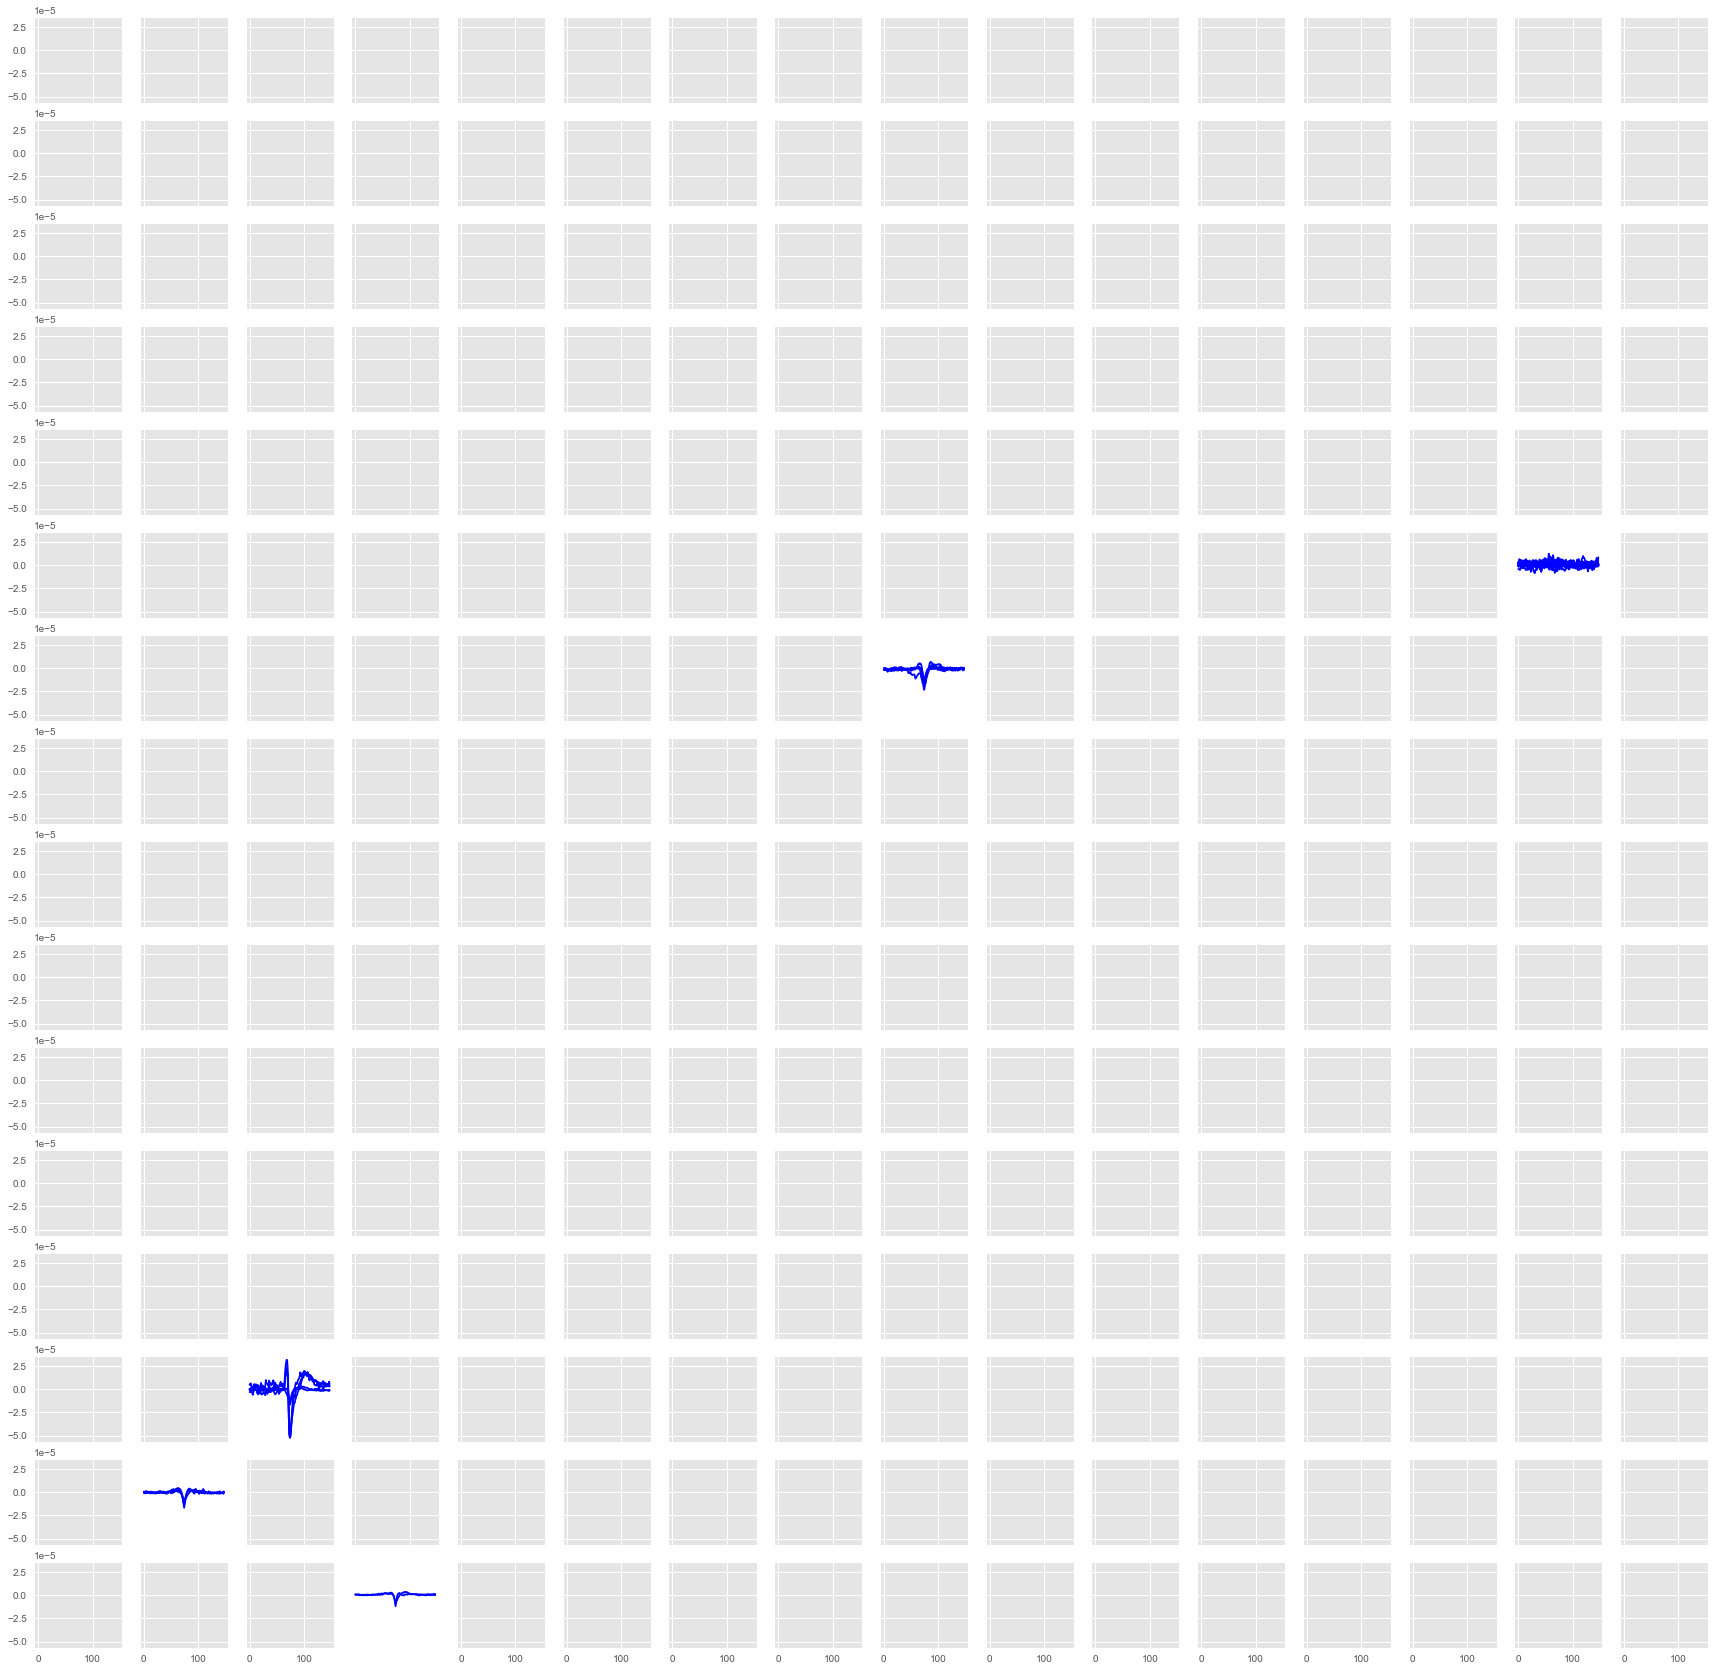

In [79]:
# plots stimmen noch nicht mit den eigentlichen channels überein
plt.style.use("seaborn")

fig, ax = plt.subplots(nrows=16, ncols=16, sharex=True, 
                       sharey=True,figsize=(30, 30))

#colors = iter(cm.jet(np.linspace(0, 1, len(unitlist_by_index))))
unique_labels = unitframe['channellabel'].unique()

for channel in unique_labels[:5]:
    # get the number of that channel (i.e, the max-channel)
    j=labeldic_invert[channel]
    print(channel)
    
    # gets the ax location for that channel m=letter, n=number
    m = label_loc_dic[channel][0]
    n = label_loc_dic[channel][1]
  
    unitlist_by_index=unitframe.loc[(unitframe['max_channel']==j)].index
    unitlist_by_channel = list(unitframe.loc[(unitframe['max_channel'])==j]['unit_ids'])
    print(unitlist_by_index)
    unitframe.loc[unitlist_by_index[0]]['channellabel']
    for i in unitlist_by_index:
        ax[m,n].plot(templates[i][j].T, color='b')
        ax[m,n].axis('off')

for key in label_loc_dic:
    m = label_loc_dic[channel][0]
    n = label_loc_dic[channel][1]
    ax[m,n].axis('off')
    ax[m,n].tick_params(axis = "x", which = "both", bottom = False, top = False)
    ax[m,n].tick_params(axis = "y", which = "both", bottom = False, top = False)



# sw.plot_unit_waveforms(recording=recording_cache, sorting=sorting_SC, unit_ids=[0], color='b', max_channels=1,
#                        set_title=None, axis_equal=True, figure=fig, ax=ax[15,15])
    
#fig.show()

In [295]:
j=unitframe.loc[(unitframe['channellabel']==channel)]['max_channel'][:1]

In [300]:
j=labeldic_invert[channel]

In [301]:
j

30

In [274]:
j = int(unitframe.loc[(unitframe['channellabel']==channel)]['max_channel'][0])

In [275]:
j

0

In [73]:
unique_channels = unitframe['max_channel'].unique()
unique_labels = unitframe['channellabel'].unique()


In [74]:
# short function to create ax locations according to MCS MEA Layout

label_loc_dic = {}
channels = list(labeldic.values())

letters= []
for key in labeldic:
    letter = labeldic[key][:1]
    letters.append(letter)
letters = list(dict.fromkeys(letters))
letters.sort()

numbers = []
for key in labeldic:
    number = labeldic[key][1:]
    numbers.append(number)
numbers = list(dict.fromkeys(numbers))
numbers.sort()
    
for i in channels:
    letter = i[:1]
    number = i[1:]
    label_loc_dic[i] = [letters.index(letter), numbers.index(number)]

In [265]:
unitframe.loc[(unitframe['channellabel']=='R12')]['max_channel'][0]

0.0

In [276]:
unitlist_by_index=unitframe.loc[(unitframe['max_channel']==j)].index

In [281]:
unitlist_by_index[1]

1

In [84]:
spiketrains = sorted_dic['sec_0-300'].get_unit_spike_train(101)

In [89]:
spiketrains[-1]*40*1e-06

299.89376

In [114]:
def spiketrains_to_spikedictionary_channel(sorting_dic, unitframe, dictkey):
    
    labels = unitframe['channellabel'].unique()
    unit_ids = sorted_dic[dictkey].get_unit_ids()
    spikechannellist = []
    spikedictionary_channel = {}
    spikedictionary_neuron = {}
    spikedictionary_channel_neuron = {}
    sub_spikedictionary_channel_neuron ={}
    
    for label in labels:
        sub_spikedictionary_channel_neuron ={}
        spikechannellist = []
        unit_i = list(unitframe.loc[(unitframe['channellabel']==label)]['unit_ids'])
        for i in unit_i:
            spiketrains = sorted_dic[dictkey].get_unit_spike_train(i)
            spikechannellist.append(list(spiketrains))
            spikedictionary_neuron[i]=spiketrains
            sub_spikedictionary_channel_neuron[i]=spiketrains
        spikedictionary_channel[label]=spikechannellist
        spikedictionary_channel_neuron[label]=sub_spikedictionary_channel_neuron
        
    return spikedictionary_channel, spikedictionary_neuron, spikedictionary_channel_neuron
    
    

In [116]:
sd_c, sd_n, sd_cn = spiketrains_to_spikedictionary_channel(
    sorting_dic = sorted_dic,
    unitframe = unitframe,
    dictkey='sec_0-300')

{11: array([  77907,   78110,  111963,  121767,  155690,  198504,  199240,
         199440,  239319,  287912,  384701,  455286,  493784,  564981,
         629862,  672895,  673981,  706036,  706138,  744876,  777191,
         818198,  855203,  855450,  855875,  971098, 1008891, 1037115,
        1087445, 1115678, 1116028, 1116830, 1123766, 1193782, 1227289,
        1227509, 1227824, 1305192, 1341253, 1396355, 1430578, 1431529,
        1450661, 1476256, 1476750, 1523743, 1610063, 1611054, 1637057,
        1653179, 1710781, 1711193, 1824853, 1848425, 1862389, 1900328,
        1934541, 1970536, 2057497, 2096187, 2141873, 2177089, 2177674,
        2257091, 2293986, 2294387, 2294686, 2294850, 2384549, 2420296,
        2462948, 2530064, 2608324, 2608628, 2616582, 2680266, 2680376,
        2721783, 2766334, 2766700, 2879726, 2889921, 2928163, 2947474,
        2947656, 2948065, 2959200, 3035717, 3036793, 3061760, 3075771,
        3087252, 3151769, 3246262, 3246425, 3247819, 3263447, 3284516,
  

In [ ]:
label = unitframe.loc[unitframe.unit_ids == i]

In [98]:
labels = unitframe['channellabel'].unique()


In [104]:
unit_i = unitframe.loc[(unitframe['channellabel']=='P12')]['unit_ids']

In [110]:
for i in unit_i:
    print(i)


90
91
92
93


In [111]:
list(unit_i)

[90, 91, 92, 93]